In [37]:
using Revise

In [38]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [39]:
using Blink

In [40]:
robot = CartPole(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 4997`, ProcessRunning), TCPSocket(RawFD(70) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(5, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(75) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 5, Nullable{Any}(true))))

In [41]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params)
net, loss = LearningMPC.lowerbound_net([4, 24, 24, 1]; regularization=0.0)
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [42]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
        LearningMPC.randomize!(x0, x_init, 0.5, σv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 50, 
            params.lcp_solver;
            termination=x -> configuration(x)[2] > π/2 || configuration(x)[2] < -π/2);
        append!(data, sink.samples)
    end
end

(::#57) (generic function with 1 method)

In [43]:
library_file = "library.jld2"
dataset_file = "cartpole-lowerbound.jld2"

"cartpole-lowerbound.jld2"

In [44]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;


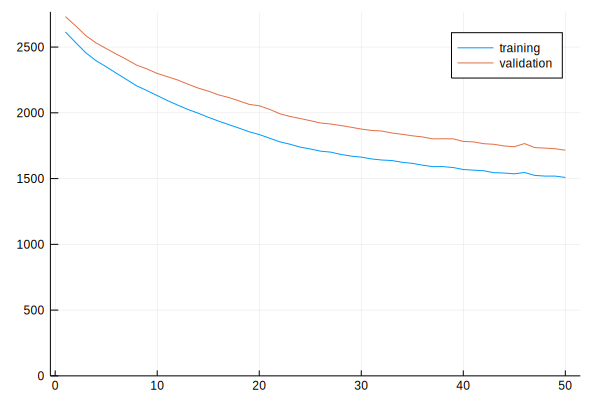

183.122418 seconds (379.70 M allocations: 21.586 GiB, 6.53% gc time)


Progress:   1%|                                         |  ETA: 8:54:47

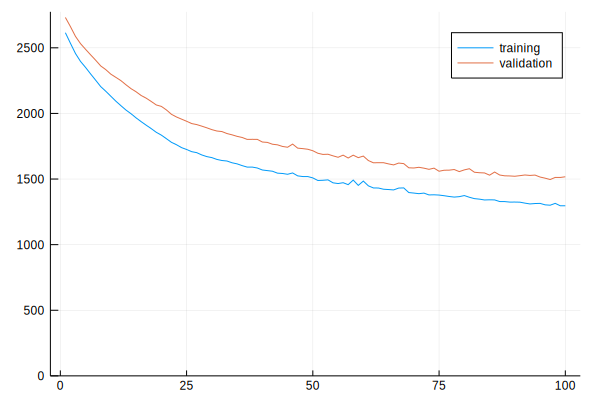

237.774475 seconds (383.24 M allocations: 21.788 GiB, 5.51% gc time)


Progress:   2%|█                                        |  ETA: 8:19:18

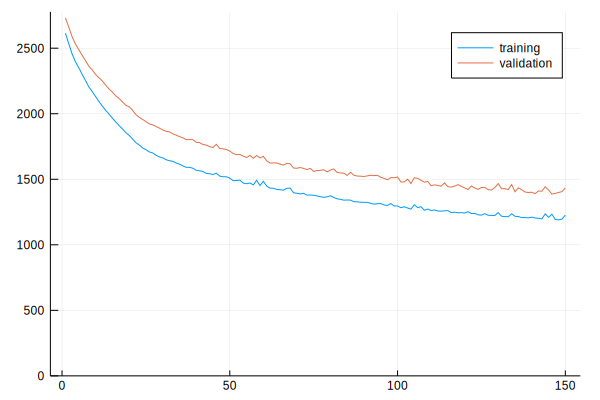

189.548992 seconds (386.80 M allocations: 21.990 GiB, 6.62% gc time)


Progress:   3%|█                                        |  ETA: 9:57:10

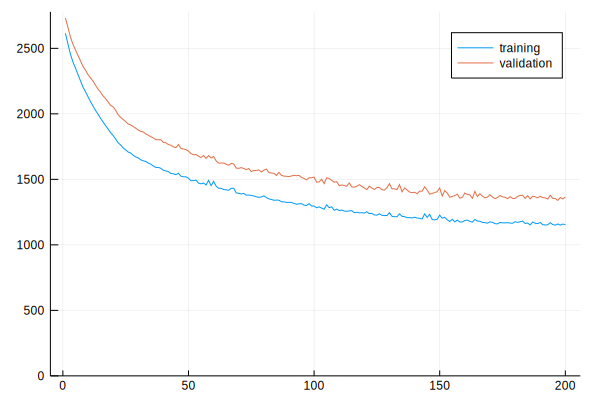

187.385395 seconds (390.35 M allocations: 22.192 GiB, 6.19% gc time)


Progress:   4%|██                                       |  ETA: 10:28:06

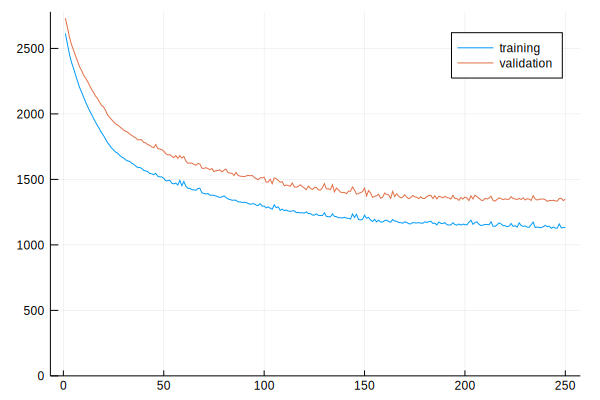

159.263980 seconds (392.35 M allocations: 22.305 GiB, 7.17% gc time)


Progress:   5%|██                                       |  ETA: 9:24:37

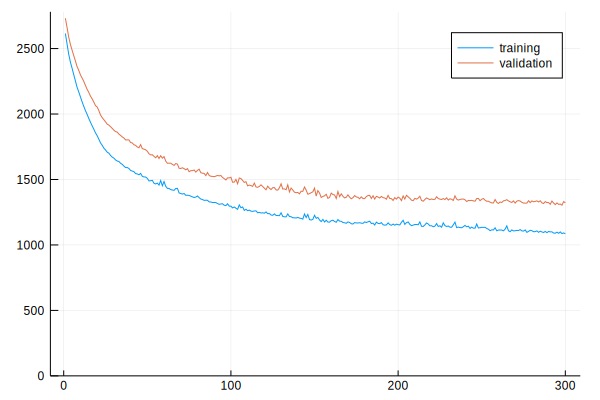

161.600705 seconds (395.90 M allocations: 22.507 GiB, 6.84% gc time)


Progress:   6%|██                                       |  ETA: 9:15:01

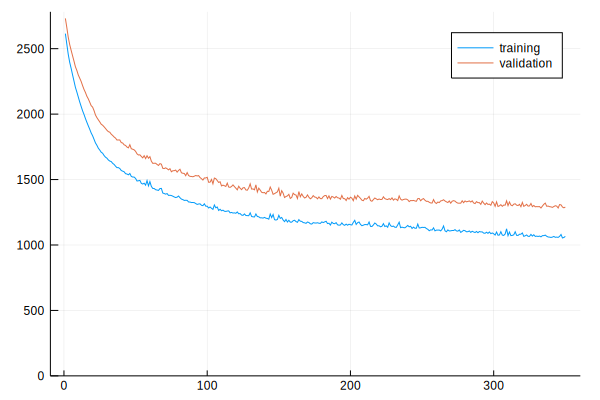

164.770316 seconds (399.46 M allocations: 22.709 GiB, 6.97% gc time)


Progress:   7%|███                                      |  ETA: 9:13:59

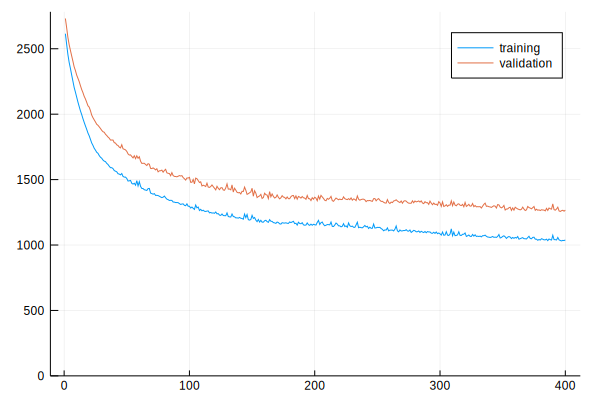

169.040562 seconds (402.74 M allocations: 22.896 GiB, 6.77% gc time)


Progress:   8%|███                                      |  ETA: 8:44:01

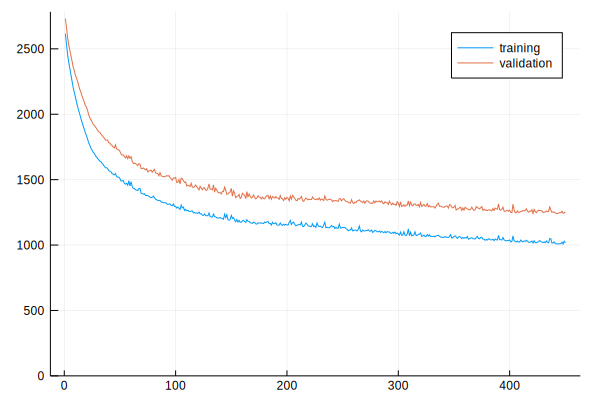

189.324938 seconds (406.29 M allocations: 23.098 GiB, 6.55% gc time)


Progress:   9%|████                                     |  ETA: 8:38:24

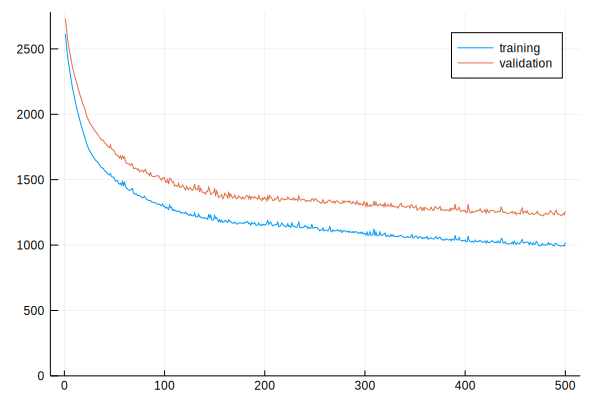

209.760550 seconds (409.85 M allocations: 23.300 GiB, 6.41% gc time)


Progress:  10%|████                                     |  ETA: 8:40:30

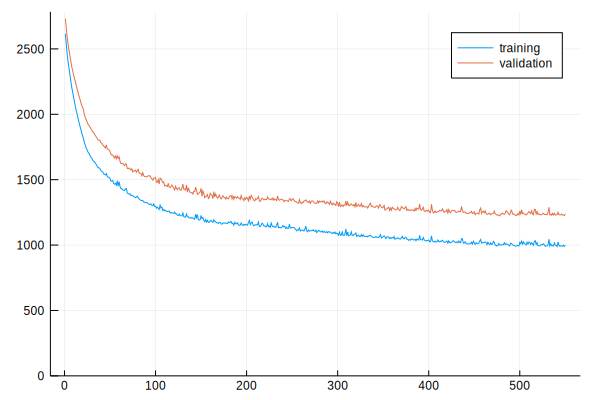

201.823774 seconds (413.32 M allocations: 23.498 GiB, 6.18% gc time)


Progress:  11%|█████                                    |  ETA: 8:41:32

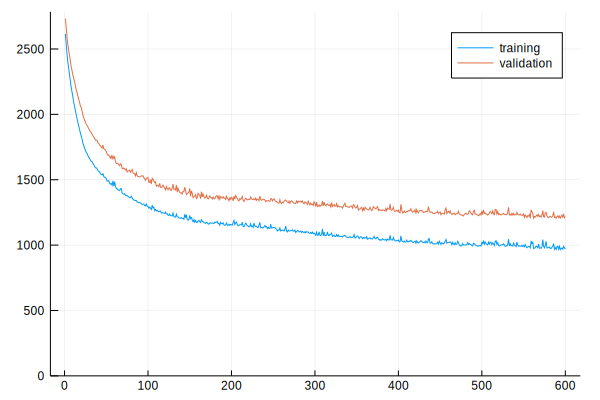

290.281273 seconds (416.88 M allocations: 23.700 GiB, 5.19% gc time)


Progress:  12%|█████                                    |  ETA: 8:37:41

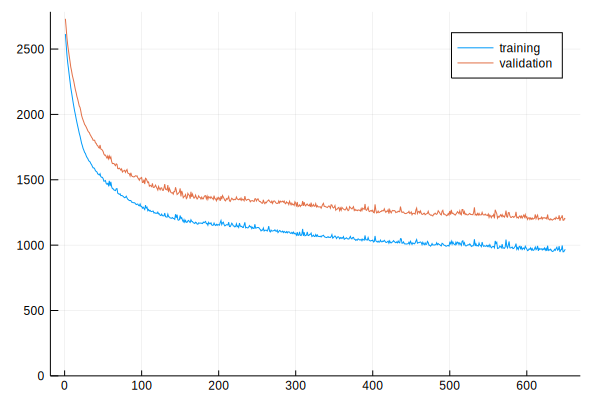

176.100421 seconds (420.43 M allocations: 23.902 GiB, 7.34% gc time)


Progress:  13%|█████                                    |  ETA: 8:31:15

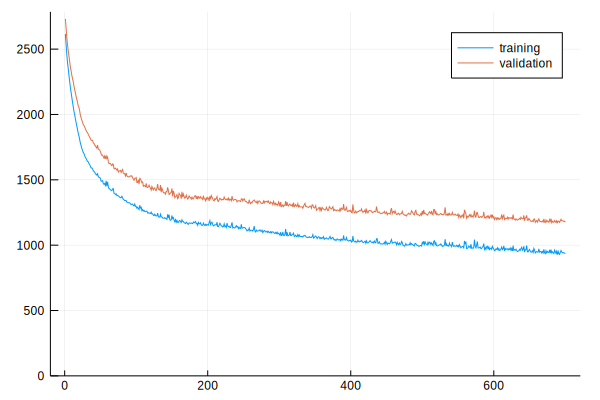

179.472351 seconds (423.99 M allocations: 24.104 GiB, 6.60% gc time)


Progress:  14%|██████                                   |  ETA: 8:19:59

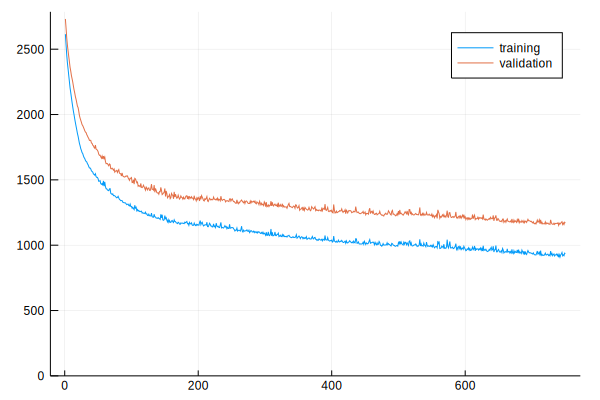

251.385868 seconds (427.54 M allocations: 24.306 GiB, 5.64% gc time)


Progress:  15%|██████                                   |  ETA: 8:09:20

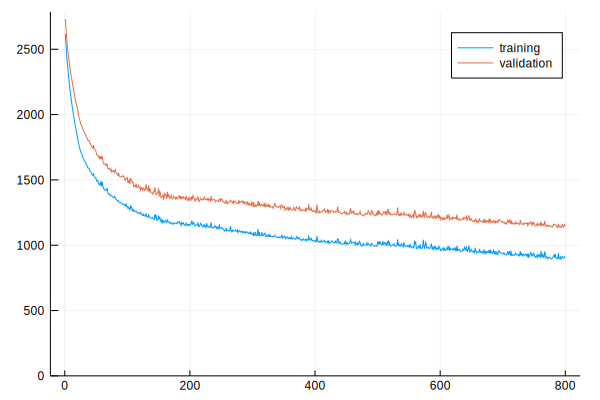

185.417839 seconds (431.10 M allocations: 24.508 GiB, 6.67% gc time)


Progress:  16%|███████                                  |  ETA: 8:05:57

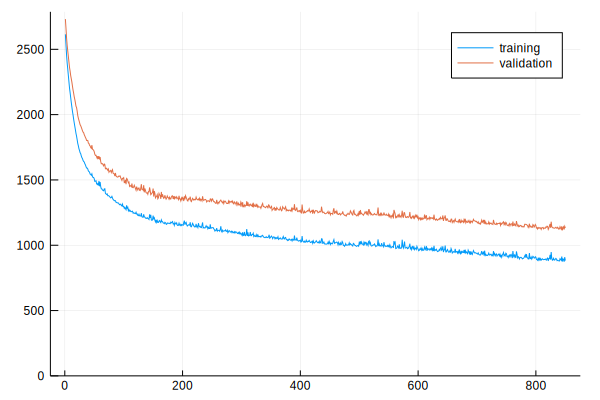

250.853676 seconds (434.65 M allocations: 24.710 GiB, 5.79% gc time)


Progress:  17%|███████                                  |  ETA: 7:56:13

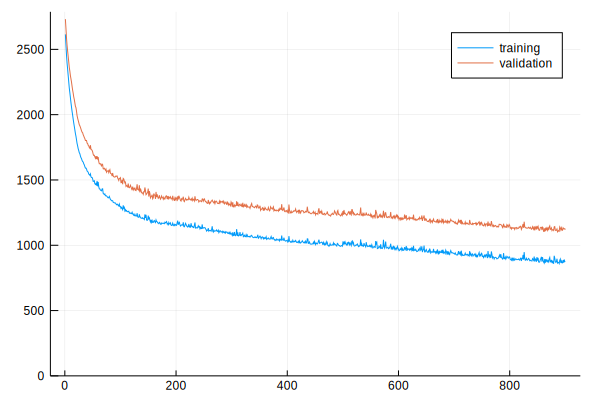

182.594465 seconds (438.21 M allocations: 24.912 GiB, 6.89% gc time)


Progress:  18%|███████                                  |  ETA: 7:41:56

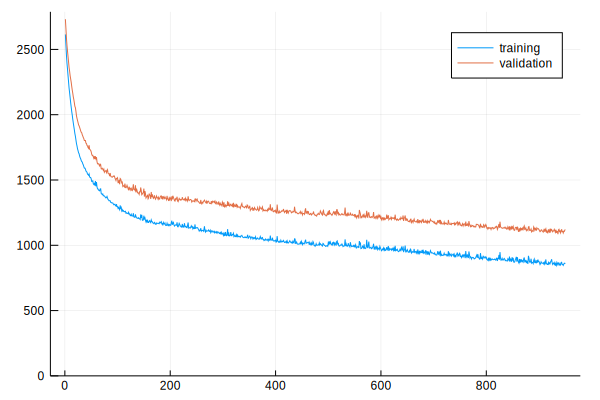

185.738367 seconds (441.76 M allocations: 25.114 GiB, 6.83% gc time)


Progress:  19%|████████                                 |  ETA: 7:29:00

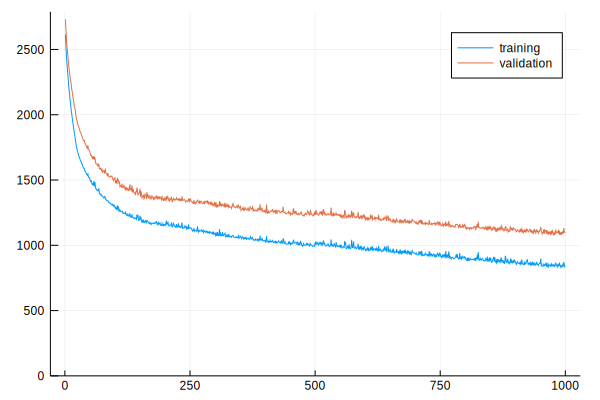

248.441619 seconds (445.32 M allocations: 25.317 GiB, 5.83% gc time)


Progress:  20%|████████                                 |  ETA: 7:20:51

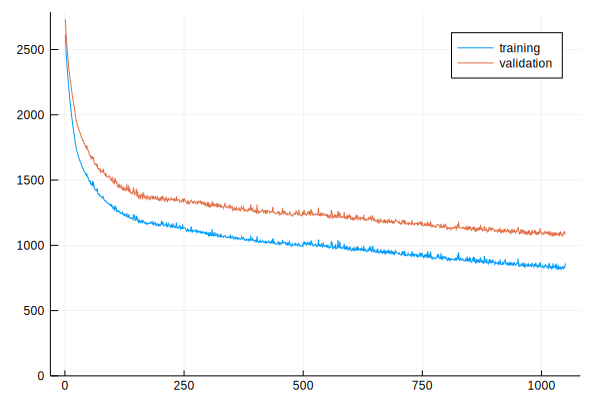

235.977737 seconds (448.87 M allocations: 25.519 GiB, 6.02% gc time)


Progress:  21%|█████████                                |  ETA: 7:14:31

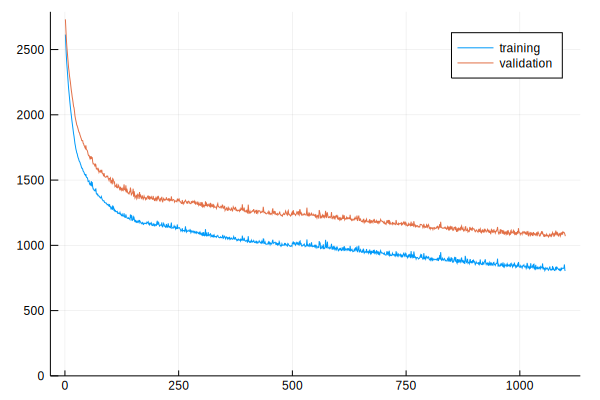

217.691450 seconds (452.43 M allocations: 25.721 GiB, 6.34% gc time)


Progress:  22%|█████████                                |  ETA: 7:07:25

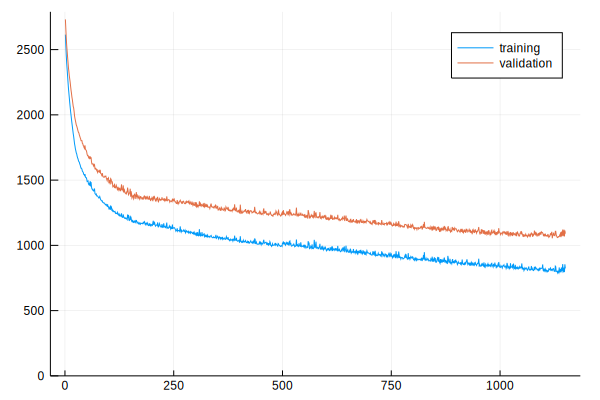

189.016516 seconds (455.98 M allocations: 25.923 GiB, 6.59% gc time)


Progress:  23%|█████████                                |  ETA: 7:03:20

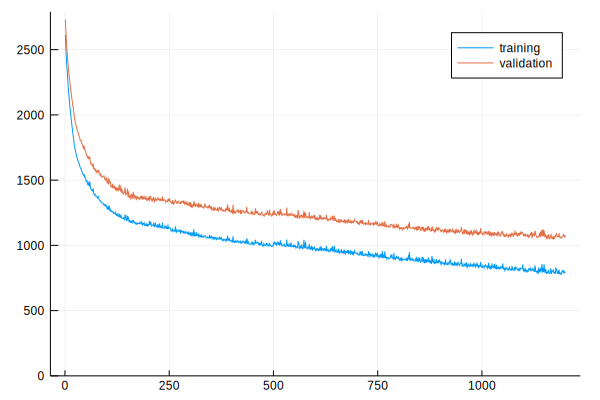

228.625947 seconds (459.54 M allocations: 26.125 GiB, 6.17% gc time)


Progress:  24%|██████████                               |  ETA: 7:02:47

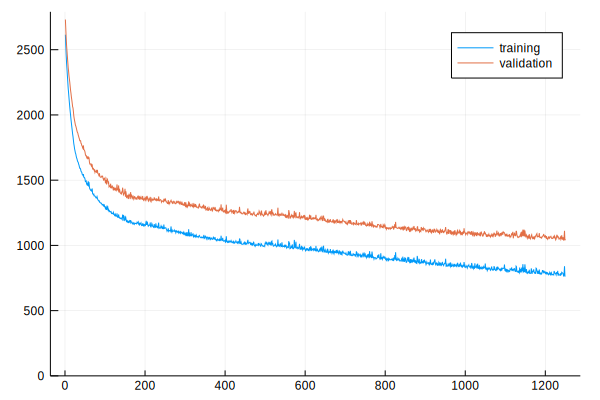

217.824755 seconds (463.09 M allocations: 26.327 GiB, 6.17% gc time)


Progress:  25%|██████████                               |  ETA: 6:56:23

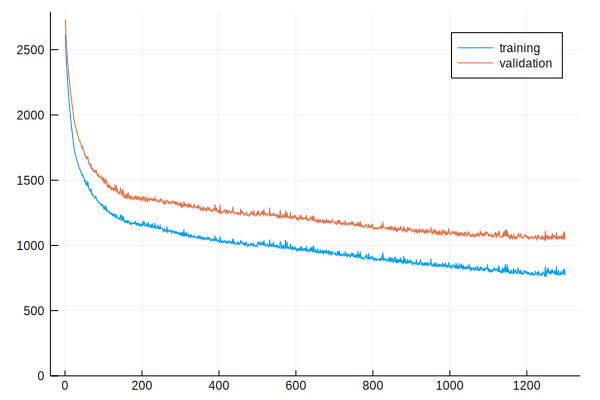

268.964288 seconds (465.66 M allocations: 26.473 GiB, 5.56% gc time)


Progress:  26%|███████████                              |  ETA: 6:51:29

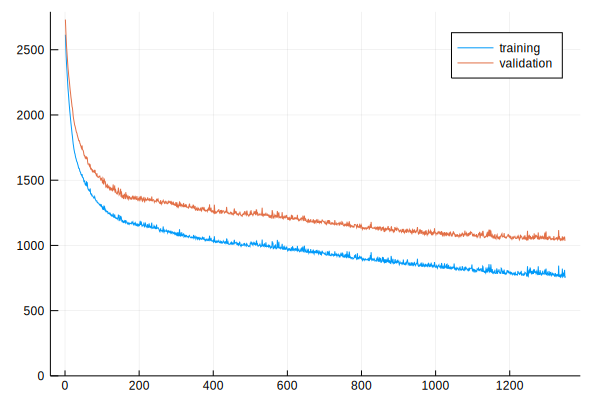

223.562304 seconds (467.44 M allocations: 26.574 GiB, 6.06% gc time)


Progress:  27%|███████████                              |  ETA: 6:42:00

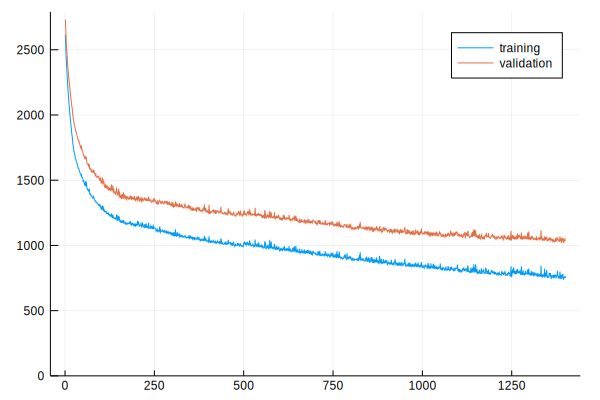

305.351775 seconds (470.99 M allocations: 26.776 GiB, 5.50% gc time)


Progress:  28%|███████████                              |  ETA: 6:42:17

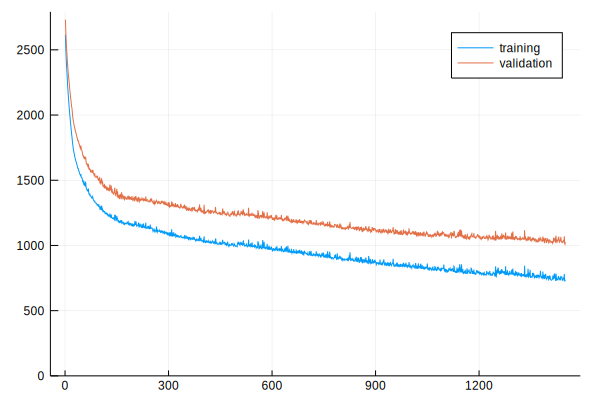

251.194093 seconds (474.55 M allocations: 26.978 GiB, 6.02% gc time)


Progress:  29%|████████████                             |  ETA: 6:35:24

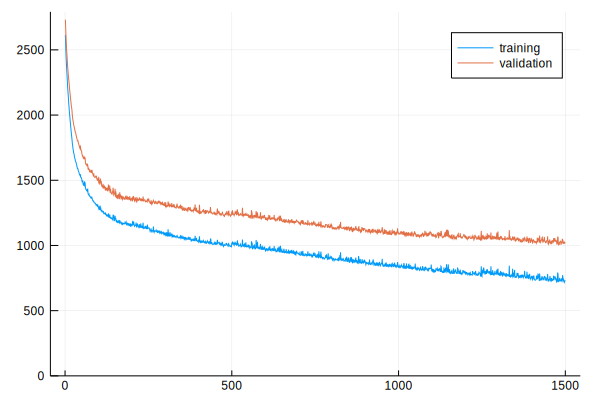

245.920283 seconds (478.10 M allocations: 27.181 GiB, 5.92% gc time)


Progress:  30%|████████████                             |  ETA: 6:34:11

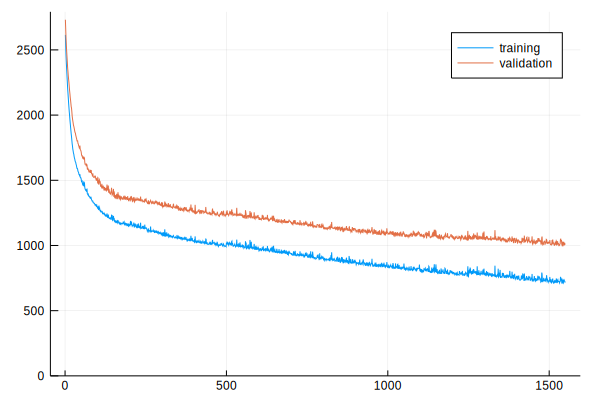

290.503896 seconds (481.66 M allocations: 27.383 GiB, 5.40% gc time)


Progress:  31%|█████████████                            |  ETA: 6:33:27

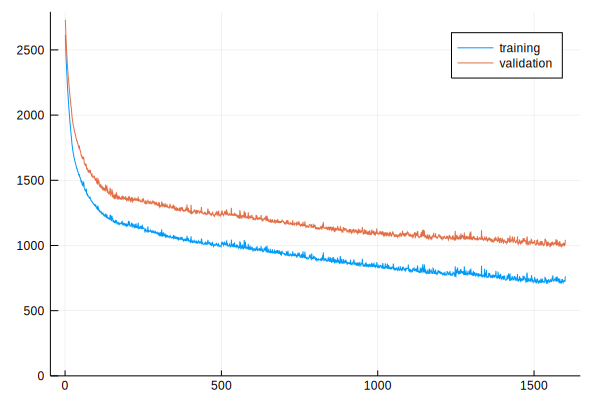

198.385871 seconds (483.75 M allocations: 27.502 GiB, 6.73% gc time)


Progress:  32%|█████████████                            |  ETA: 6:23:49

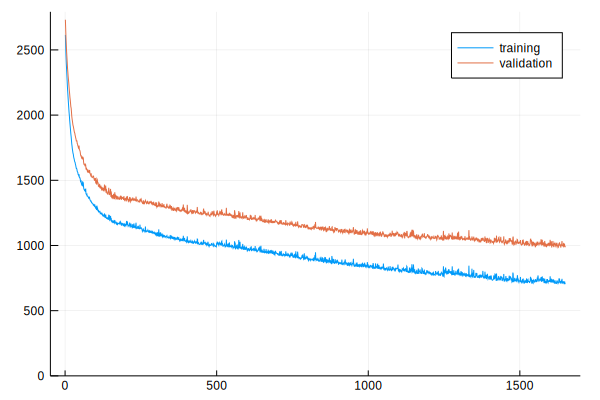

258.248230 seconds (487.31 M allocations: 27.704 GiB, 5.99% gc time)


Progress:  33%|██████████████                           |  ETA: 6:19:23

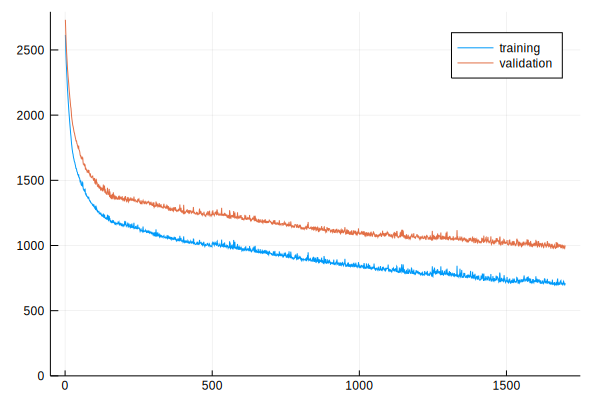

212.118368 seconds (490.86 M allocations: 27.906 GiB, 6.72% gc time)


Progress:  34%|██████████████                           |  ETA: 6:15:59

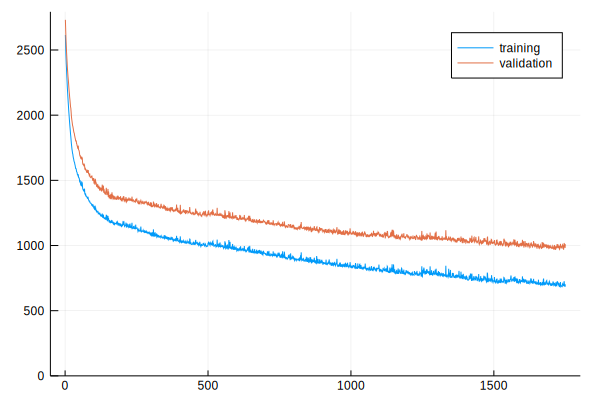

204.023103 seconds (494.42 M allocations: 28.108 GiB, 6.90% gc time)


Progress:  35%|██████████████                           |  ETA: 6:07:43

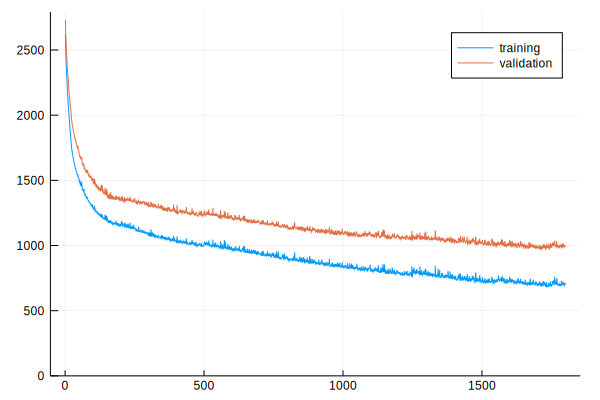

259.563241 seconds (496.51 M allocations: 28.227 GiB, 6.06% gc time)


Progress:  36%|███████████████                          |  ETA: 6:01:00

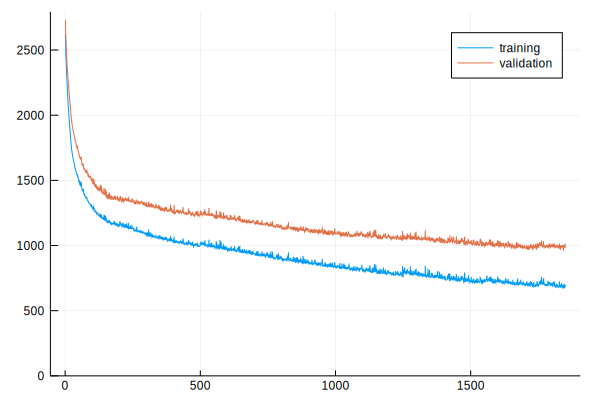

202.931225 seconds (500.06 M allocations: 28.429 GiB, 6.74% gc time)


Progress:  37%|███████████████                          |  ETA: 5:53:00

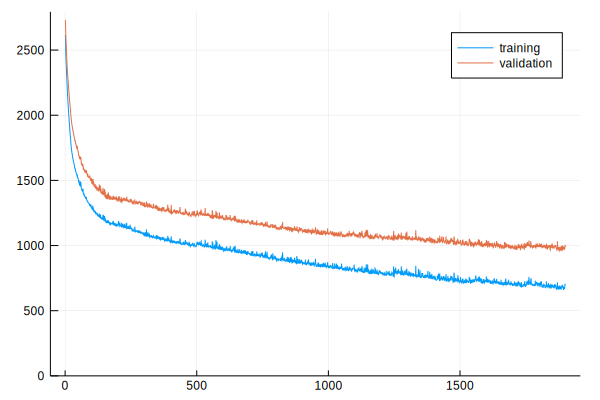

224.573832 seconds (503.62 M allocations: 28.631 GiB, 6.64% gc time)


Progress:  38%|████████████████                         |  ETA: 5:49:02

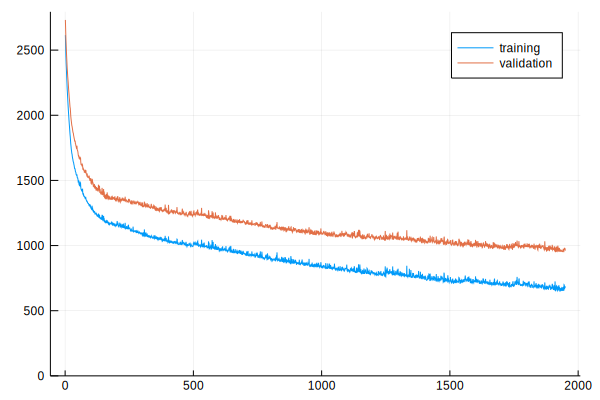

268.340450 seconds (507.17 M allocations: 28.833 GiB, 5.98% gc time)


Progress:  39%|████████████████                         |  ETA: 5:42:47

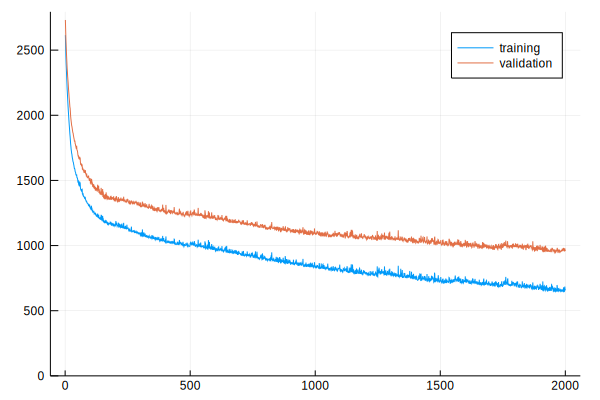

282.199492 seconds (510.73 M allocations: 29.035 GiB, 5.89% gc time)


Progress:  40%|████████████████                         |  ETA: 5:37:59

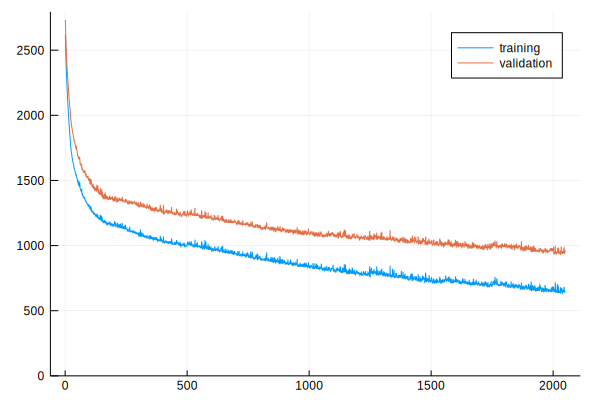

207.853658 seconds (514.28 M allocations: 29.237 GiB, 6.95% gc time)


Progress:  41%|█████████████████                        |  ETA: 5:33:50

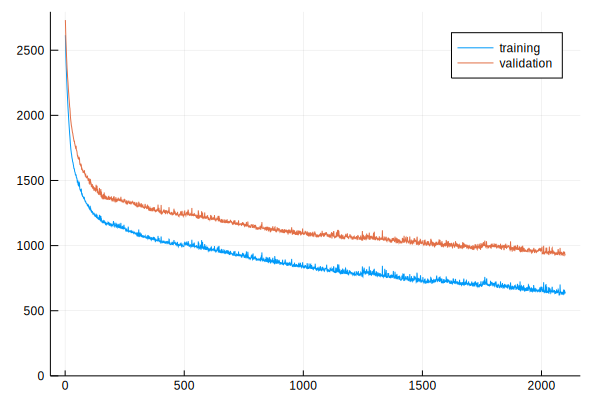

272.498985 seconds (517.84 M allocations: 29.439 GiB, 6.04% gc time)


Progress:  42%|█████████████████                        |  ETA: 5:30:50

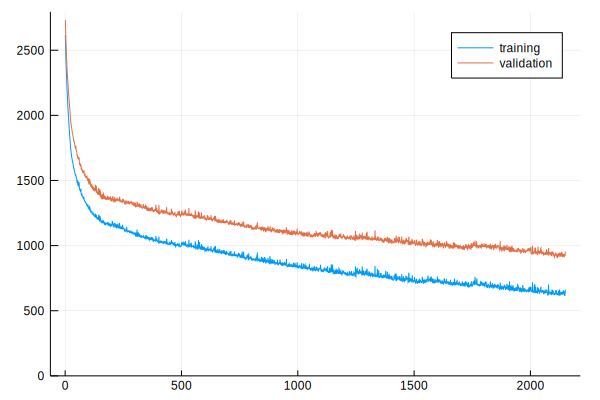

236.041444 seconds (521.39 M allocations: 29.642 GiB, 6.51% gc time)


Progress:  43%|██████████████████                       |  ETA: 5:24:07

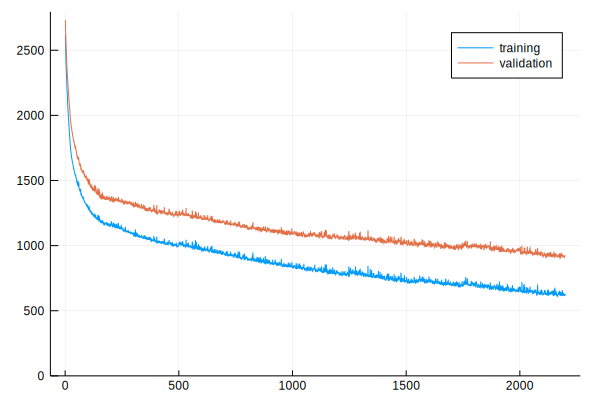

216.188438 seconds (524.95 M allocations: 29.844 GiB, 6.82% gc time)


Progress:  44%|██████████████████                       |  ETA: 5:16:47

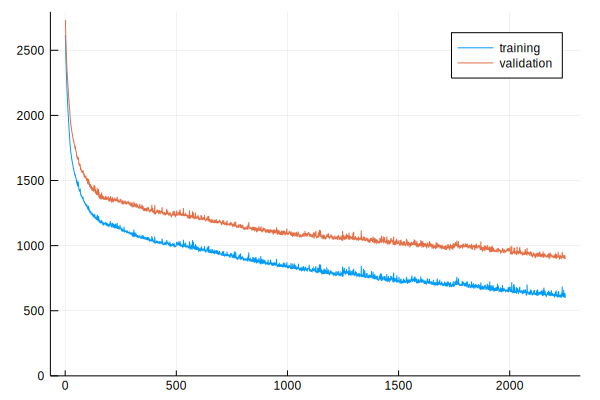

326.404539 seconds (528.50 M allocations: 30.046 GiB, 5.55% gc time)


Progress:  45%|██████████████████                       |  ETA: 5:14:40

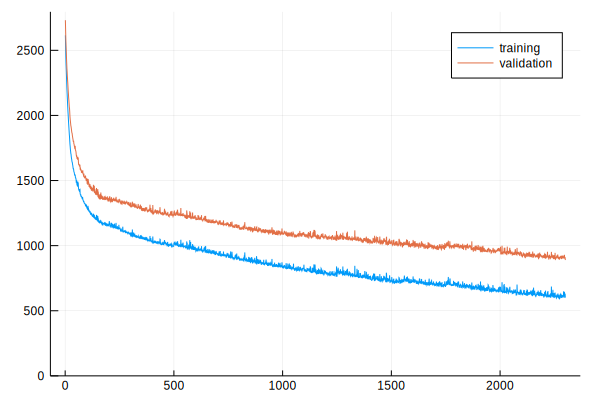

226.694921 seconds (532.06 M allocations: 30.248 GiB, 6.81% gc time)


Progress:  46%|███████████████████                      |  ETA: 5:07:53

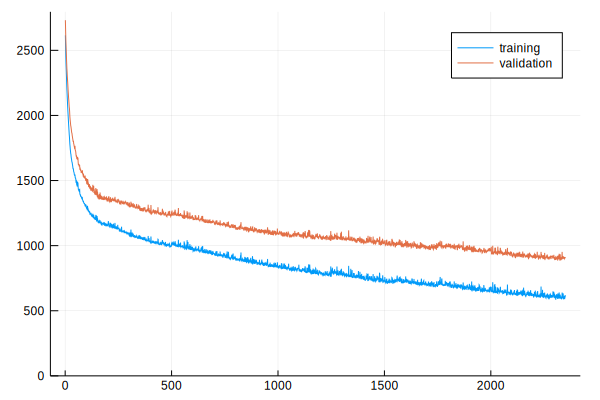

252.627426 seconds (535.61 M allocations: 30.450 GiB, 6.13% gc time)


Progress:  47%|███████████████████                      |  ETA: 5:03:20

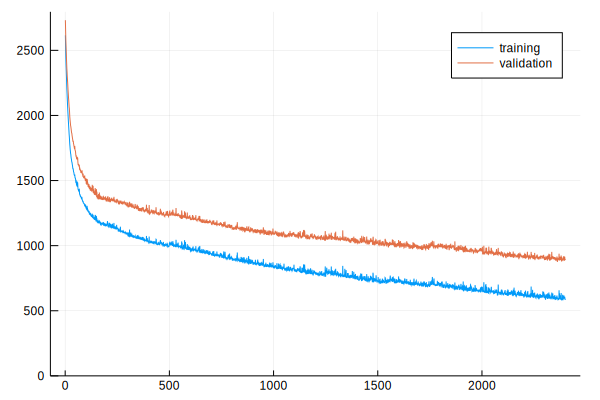

242.788967 seconds (539.17 M allocations: 30.652 GiB, 6.32% gc time)


Progress:  48%|████████████████████                     |  ETA: 4:56:48

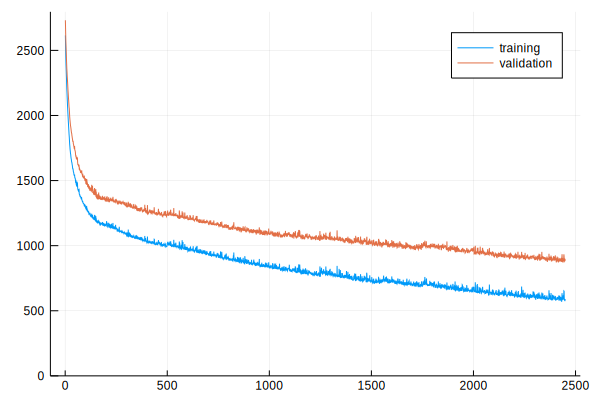

312.520226 seconds (542.72 M allocations: 30.854 GiB, 5.77% gc time)


Progress:  49%|████████████████████                     |  ETA: 4:55:57

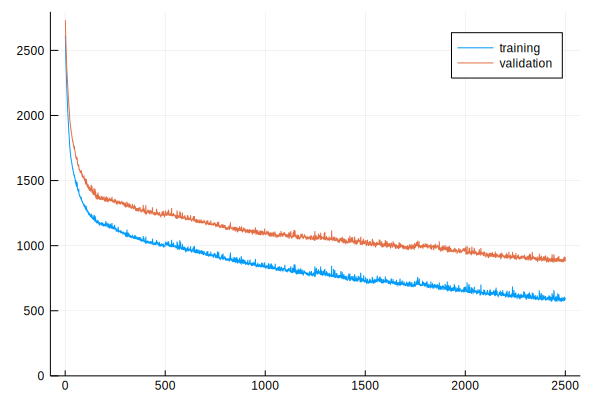

277.632835 seconds (546.28 M allocations: 31.056 GiB, 6.17% gc time)


Progress:  50%|████████████████████                     |  ETA: 4:52:08

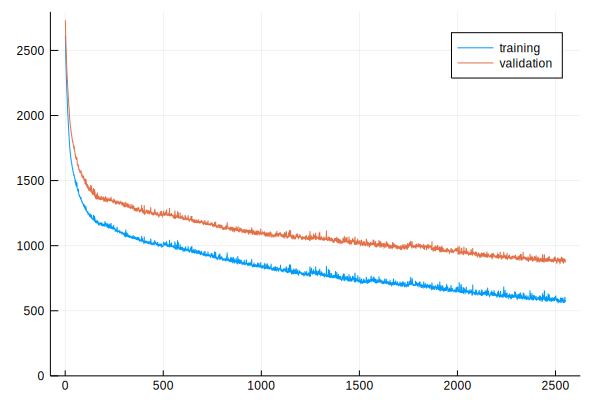

308.238662 seconds (549.83 M allocations: 31.258 GiB, 5.83% gc time)


Progress:  51%|█████████████████████                    |  ETA: 4:46:19

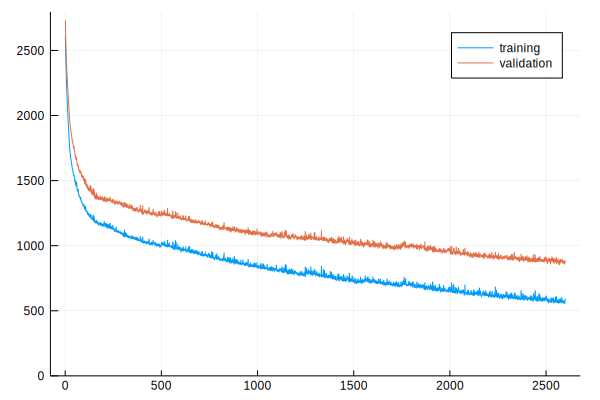

239.717176 seconds (553.39 M allocations: 31.461 GiB, 6.71% gc time)


Progress:  52%|█████████████████████                    |  ETA: 4:39:31

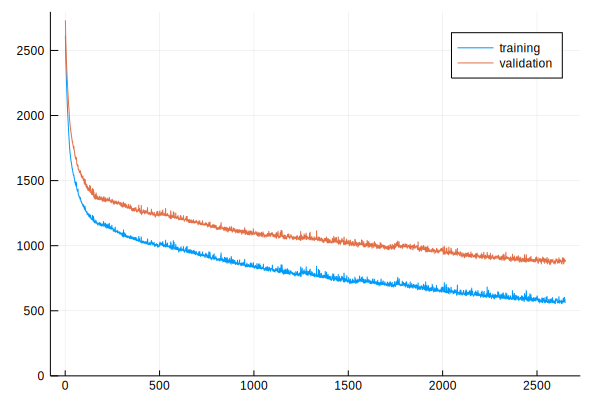

314.730128 seconds (556.94 M allocations: 31.663 GiB, 5.74% gc time)


Progress:  53%|██████████████████████                   |  ETA: 4:37:23

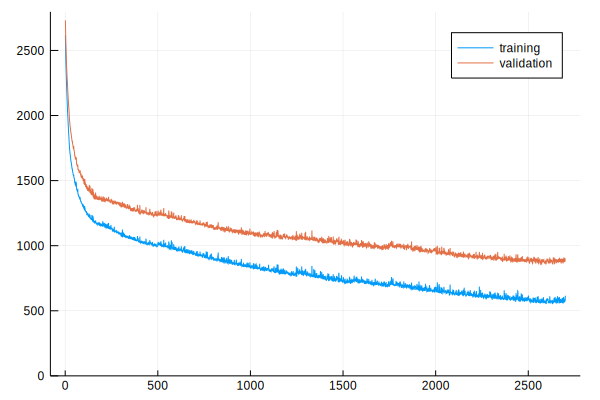

295.934152 seconds (560.50 M allocations: 31.865 GiB, 6.13% gc time)


Progress:  54%|██████████████████████                   |  ETA: 4:34:28

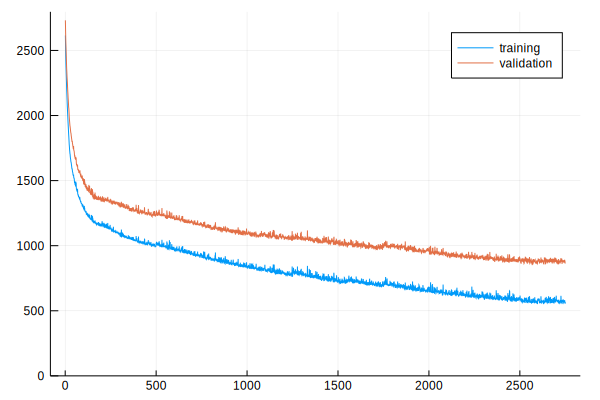

236.658062 seconds (564.05 M allocations: 32.067 GiB, 6.81% gc time)


Progress:  55%|███████████████████████                  |  ETA: 4:29:25

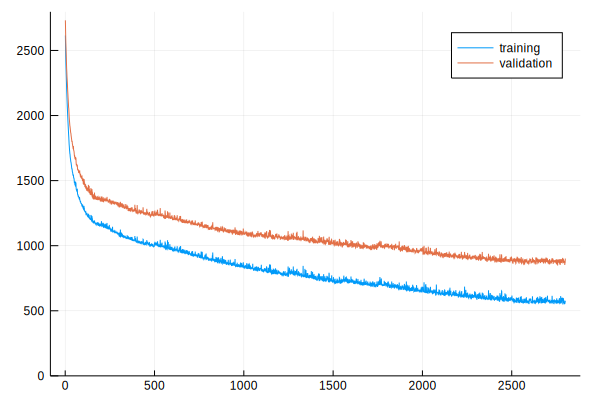

251.451928 seconds (567.61 M allocations: 32.269 GiB, 6.45% gc time)


Progress:  56%|███████████████████████                  |  ETA: 4:22:39

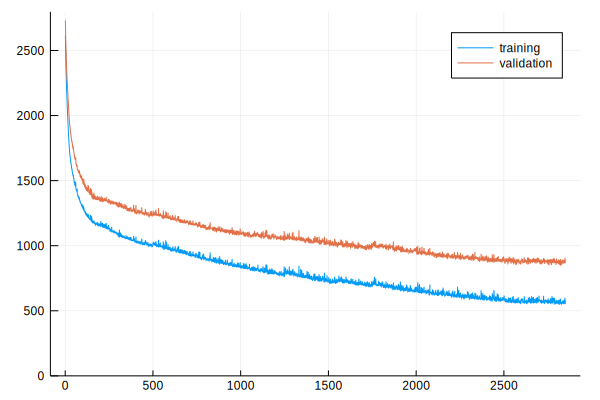

291.822447 seconds (569.56 M allocations: 32.380 GiB, 5.89% gc time)


Progress:  57%|███████████████████████                  |  ETA: 4:16:20

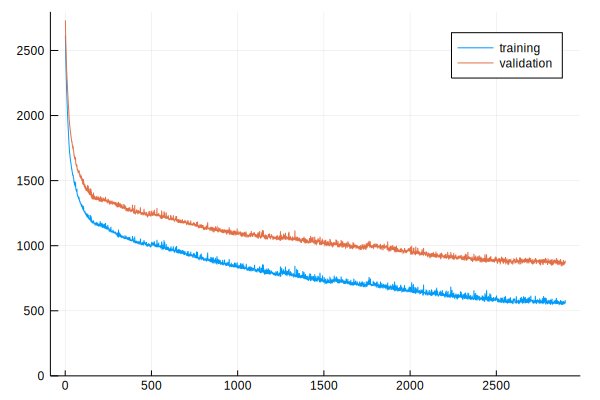

261.536996 seconds (573.12 M allocations: 32.582 GiB, 6.41% gc time)


Progress:  58%|████████████████████████                 |  ETA: 4:11:25

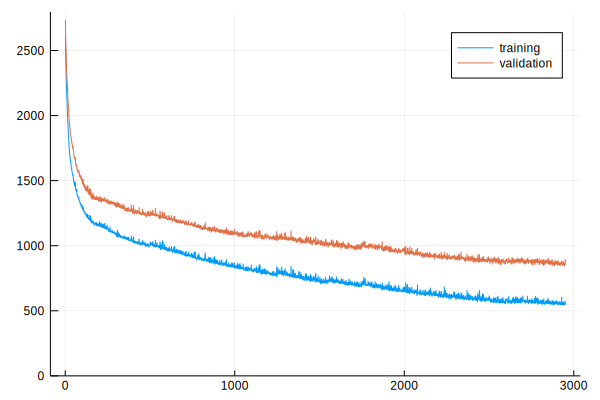

237.724294 seconds (576.67 M allocations: 32.784 GiB, 6.96% gc time)


Progress:  59%|████████████████████████                 |  ETA: 4:04:34

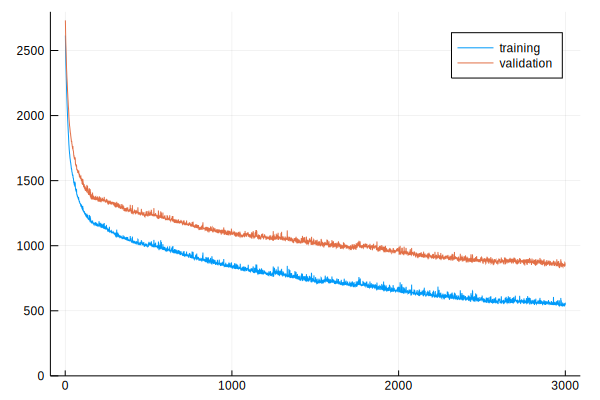

238.733354 seconds (580.23 M allocations: 32.986 GiB, 6.73% gc time)


Progress:  60%|█████████████████████████                |  ETA: 3:59:22

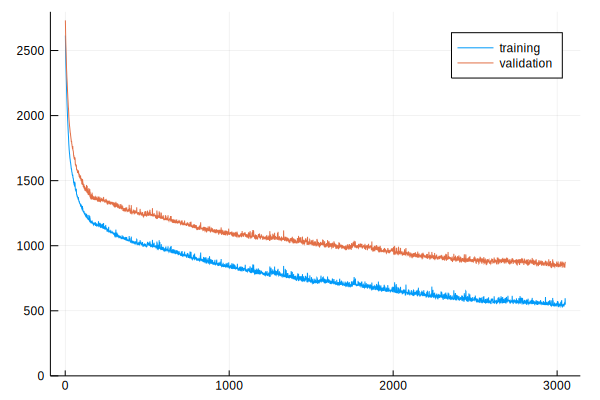

236.950868 seconds (583.78 M allocations: 33.189 GiB, 6.89% gc time)


Progress:  61%|█████████████████████████                |  ETA: 3:52:36

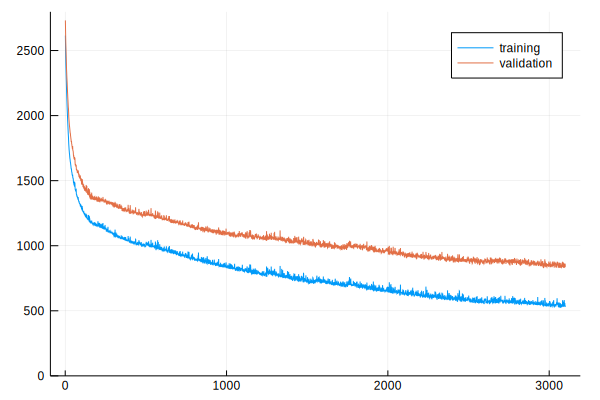

242.377099 seconds (587.34 M allocations: 33.391 GiB, 6.97% gc time)


Progress:  62%|█████████████████████████                |  ETA: 3:47:35

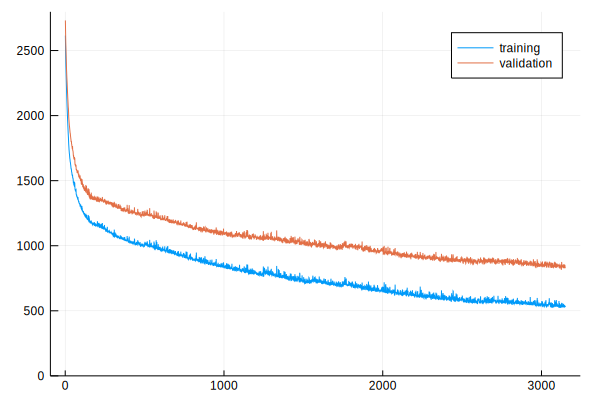

290.474854 seconds (590.89 M allocations: 33.593 GiB, 6.39% gc time)


Progress:  63%|██████████████████████████               |  ETA: 3:42:41

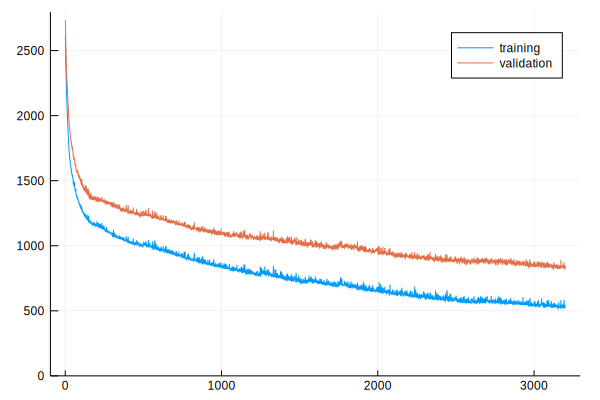

295.231466 seconds (594.45 M allocations: 33.795 GiB, 6.24% gc time)


Progress:  64%|██████████████████████████               |  ETA: 3:36:30

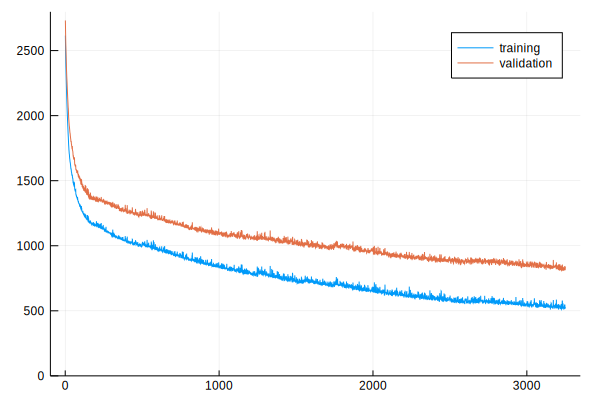

369.078007 seconds (598.00 M allocations: 33.997 GiB, 5.54% gc time)


Progress:  65%|███████████████████████████              |  ETA: 3:31:24

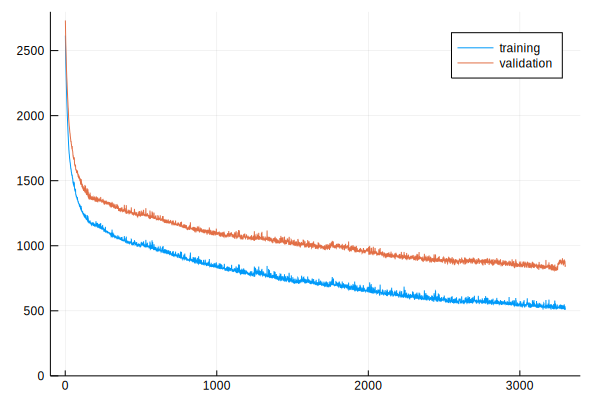

310.976767 seconds (601.56 M allocations: 34.199 GiB, 6.05% gc time)


Progress:  66%|███████████████████████████              |  ETA: 3:27:10

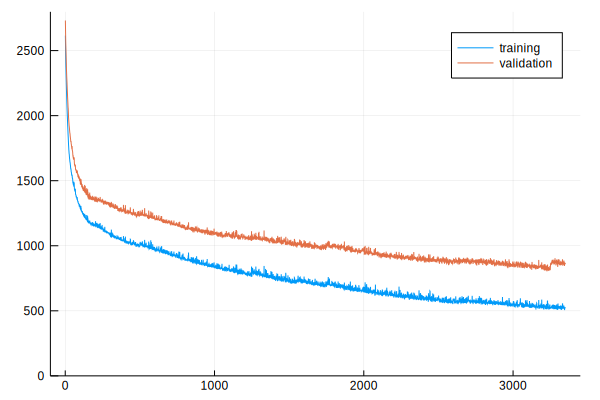

268.635053 seconds (605.11 M allocations: 34.401 GiB, 6.51% gc time)


Progress:  67%|███████████████████████████              |  ETA: 3:20:52

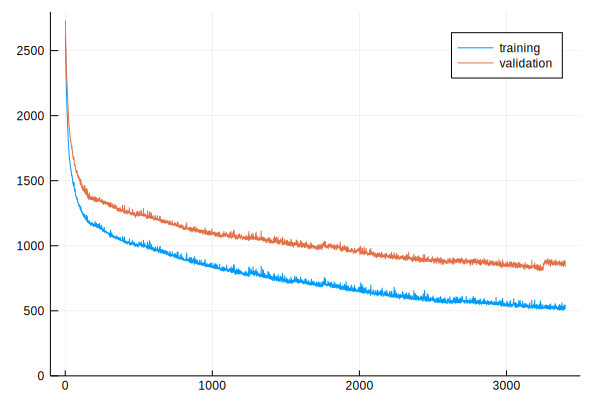

307.263817 seconds (608.67 M allocations: 34.603 GiB, 6.21% gc time)


Progress:  68%|████████████████████████████             |  ETA: 3:14:57

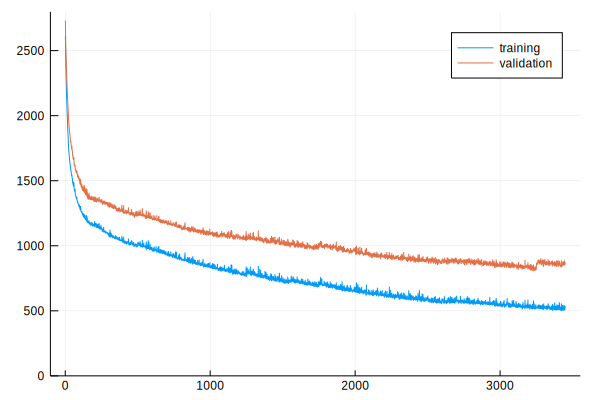

260.164213 seconds (612.22 M allocations: 34.805 GiB, 6.58% gc time)


Progress:  69%|████████████████████████████             |  ETA: 3:09:22

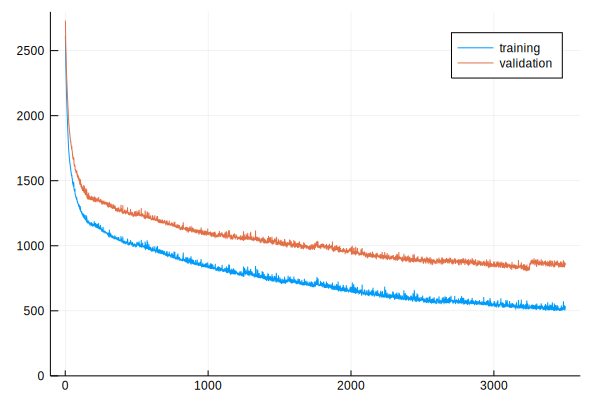

267.101979 seconds (615.78 M allocations: 35.007 GiB, 6.55% gc time)


Progress:  70%|█████████████████████████████            |  ETA: 3:02:56

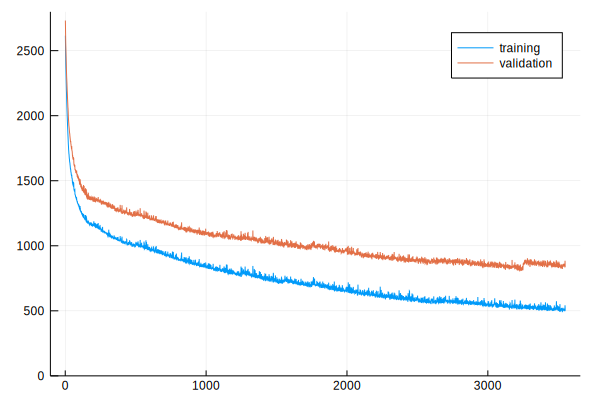

361.334717 seconds (619.33 M allocations: 35.210 GiB, 5.31% gc time)


Progress:  71%|█████████████████████████████            |  ETA: 2:57:14

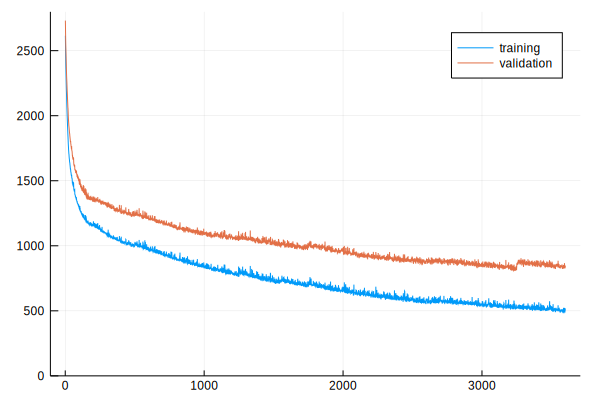

254.096202 seconds (622.89 M allocations: 35.412 GiB, 6.67% gc time)


Progress:  72%|██████████████████████████████           |  ETA: 2:50:43

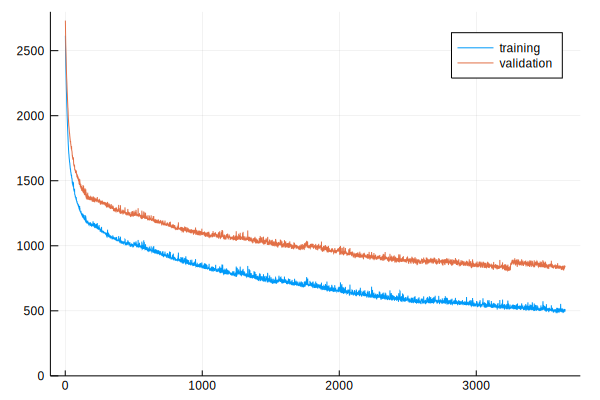

345.511913 seconds (626.44 M allocations: 35.614 GiB, 5.82% gc time)


Progress:  73%|██████████████████████████████           |  ETA: 2:44:47

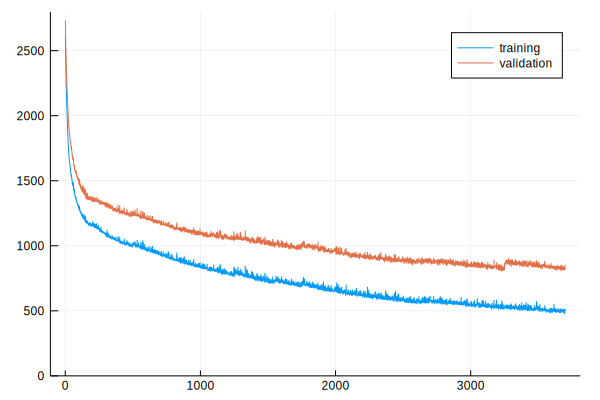

328.011636 seconds (630.00 M allocations: 35.816 GiB, 5.83% gc time)


Progress:  74%|██████████████████████████████           |  ETA: 2:38:47

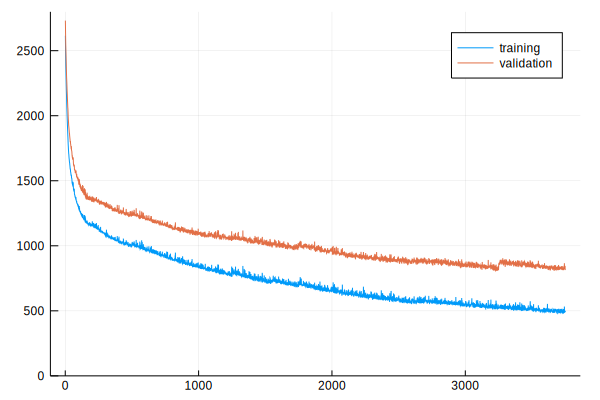

250.921046 seconds (633.55 M allocations: 36.018 GiB, 6.93% gc time)


Progress:  75%|███████████████████████████████          |  ETA: 2:32:30

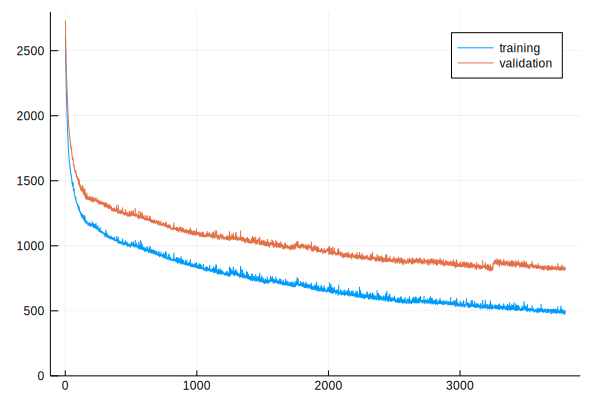

254.325599 seconds (637.11 M allocations: 36.220 GiB, 6.72% gc time)


Progress:  76%|███████████████████████████████          |  ETA: 2:26:08

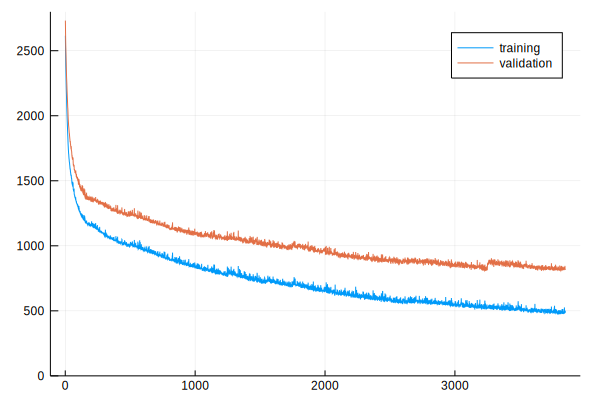

441.523191 seconds (640.66 M allocations: 36.422 GiB, 5.28% gc time)


Progress:  77%|████████████████████████████████         |  ETA: 2:20:39

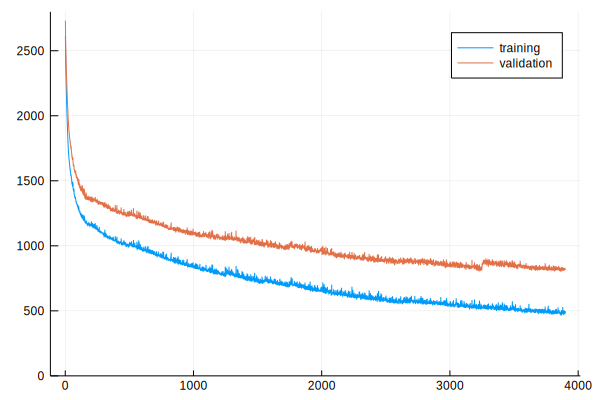

274.110321 seconds (644.22 M allocations: 36.624 GiB, 6.48% gc time)


Progress:  78%|████████████████████████████████         |  ETA: 2:14:24

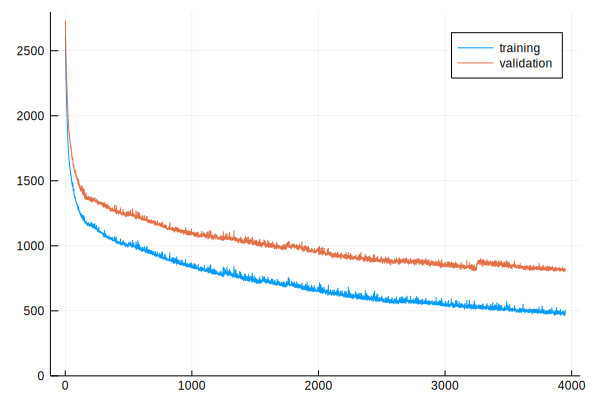

346.297483 seconds (647.77 M allocations: 36.826 GiB, 5.78% gc time)


Progress:  79%|████████████████████████████████         |  ETA: 2:08:31

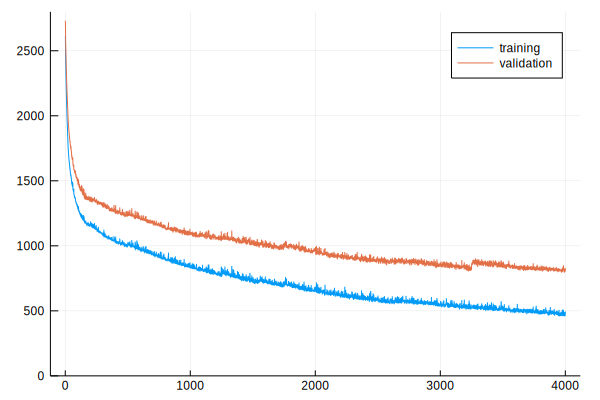

261.943563 seconds (651.33 M allocations: 37.029 GiB, 6.76% gc time)


Progress:  80%|█████████████████████████████████        |  ETA: 2:02:10

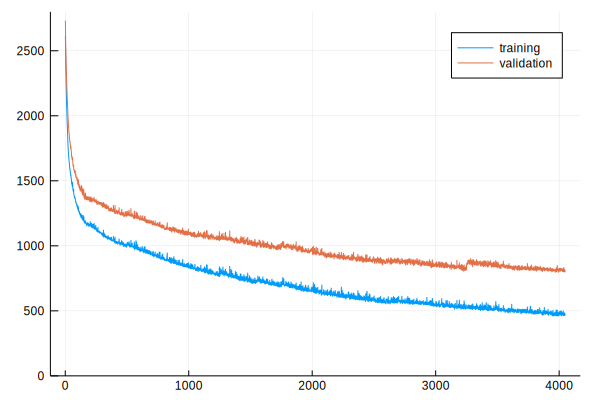

309.416080 seconds (654.88 M allocations: 37.231 GiB, 6.14% gc time)


Progress:  81%|█████████████████████████████████        |  ETA: 1:56:00

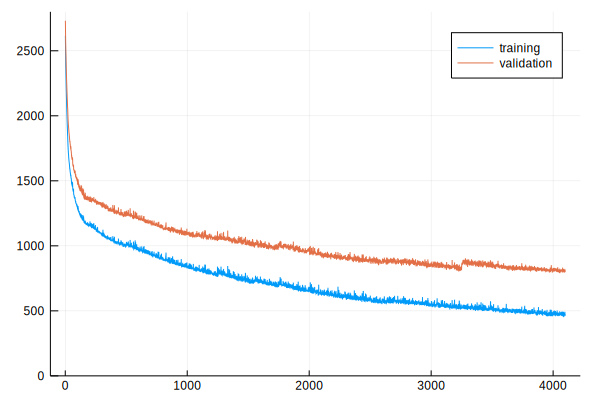

281.502746 seconds (658.44 M allocations: 37.433 GiB, 6.62% gc time)


Progress:  82%|██████████████████████████████████       |  ETA: 1:49:46

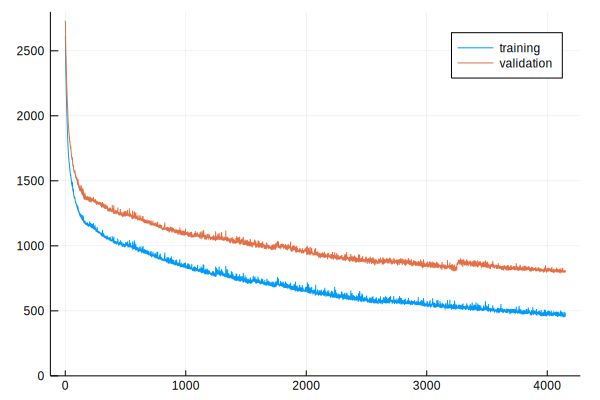

307.765227 seconds (661.99 M allocations: 37.635 GiB, 6.13% gc time)


Progress:  83%|██████████████████████████████████       |  ETA: 1:44:09

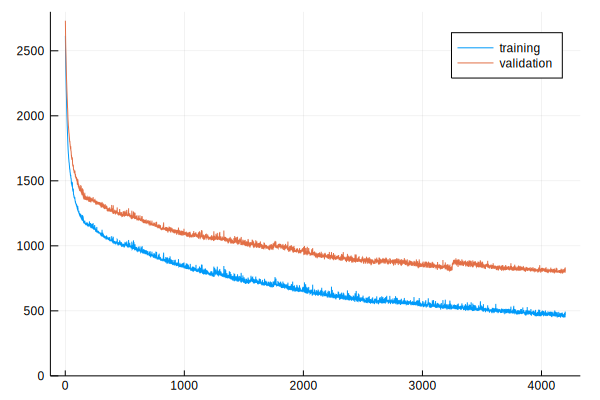

267.165199 seconds (665.55 M allocations: 37.837 GiB, 6.91% gc time)


Progress:  84%|██████████████████████████████████       |  ETA: 1:37:51

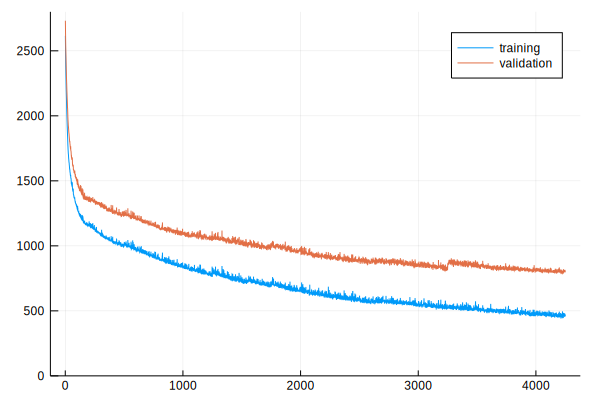

305.041595 seconds (669.10 M allocations: 38.039 GiB, 6.44% gc time)


Progress:  85%|███████████████████████████████████      |  ETA: 1:31:42

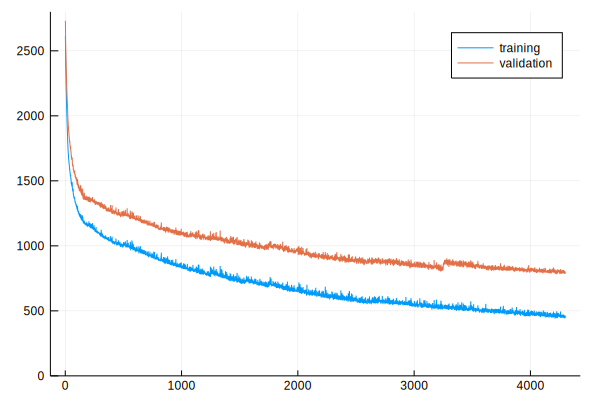

344.058724 seconds (672.66 M allocations: 38.241 GiB, 6.07% gc time)


Progress:  86%|███████████████████████████████████      |  ETA: 1:25:39

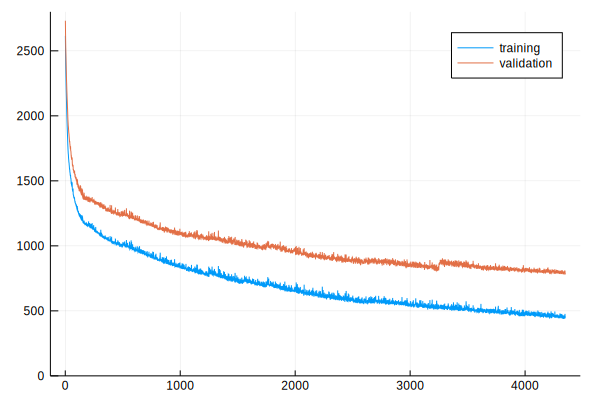

275.220485 seconds (676.21 M allocations: 38.443 GiB, 6.63% gc time)


Progress:  87%|████████████████████████████████████     |  ETA: 1:19:31

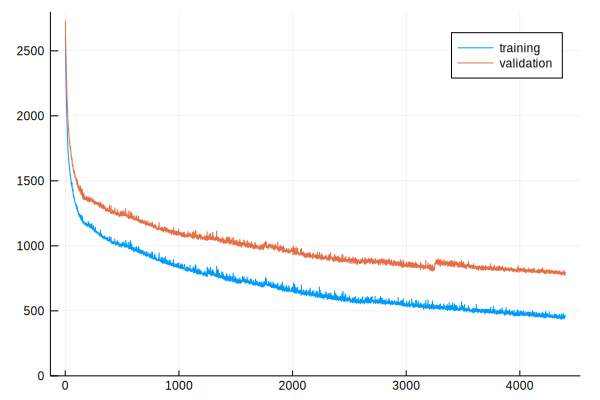

363.136535 seconds (679.77 M allocations: 38.645 GiB, 6.00% gc time)


Progress:  88%|████████████████████████████████████     |  ETA: 1:13:30

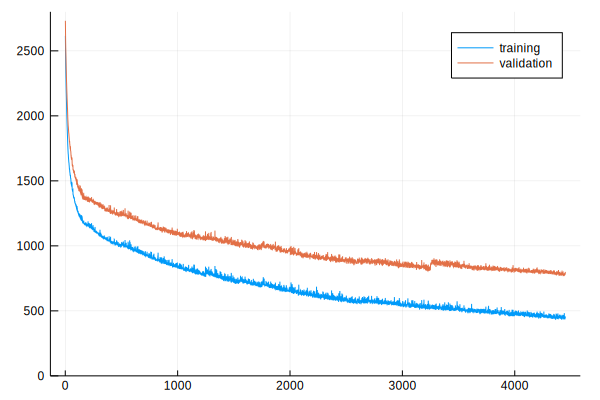

279.932417 seconds (683.32 M allocations: 38.847 GiB, 6.91% gc time)


Progress:  89%|████████████████████████████████████     |  ETA: 1:07:36

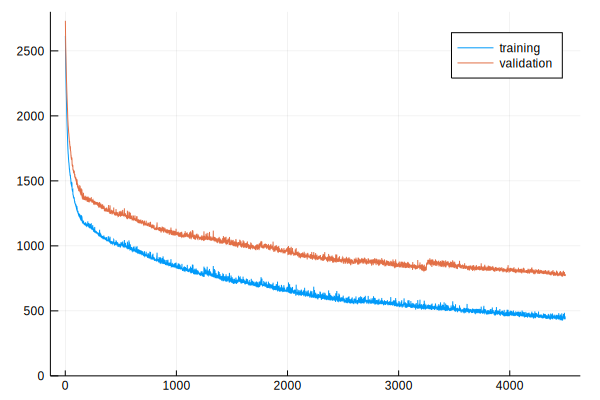

317.830419 seconds (686.88 M allocations: 39.050 GiB, 6.25% gc time)


Progress:  90%|█████████████████████████████████████    |  ETA: 1:01:27

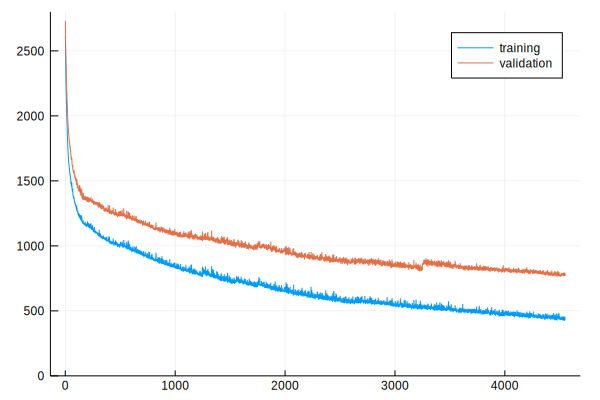

280.555094 seconds (690.43 M allocations: 39.252 GiB, 6.89% gc time)


Progress:  91%|█████████████████████████████████████    |  ETA: 0:55:26

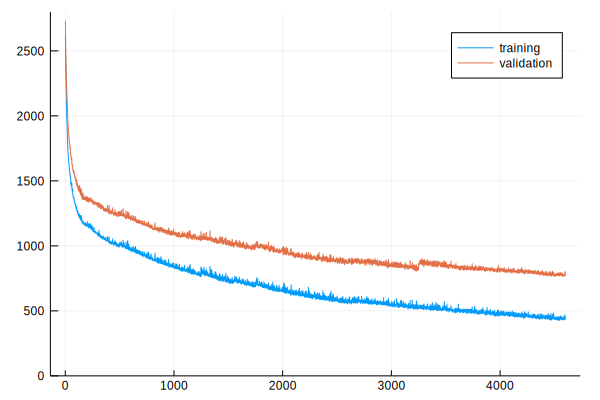

285.247543 seconds (692.61 M allocations: 39.375 GiB, 6.77% gc time)


Progress:  92%|██████████████████████████████████████   |  ETA: 0:49:13

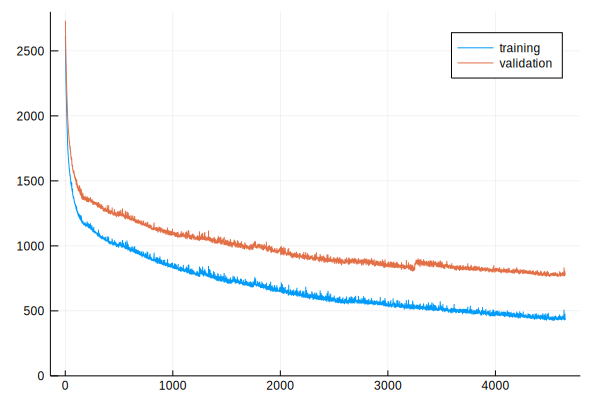

356.183682 seconds (696.16 M allocations: 39.577 GiB, 5.97% gc time)


Progress:  93%|██████████████████████████████████████   |  ETA: 0:43:16

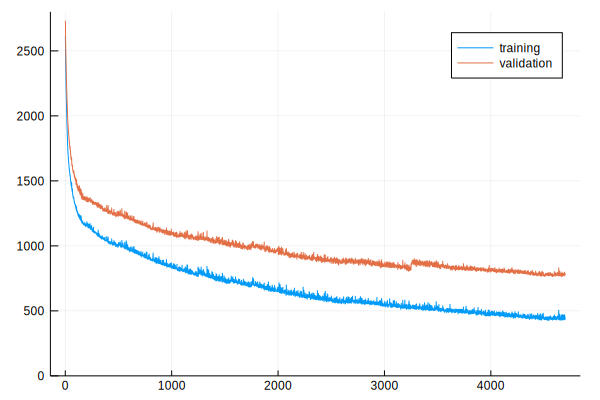

280.473906 seconds (699.72 M allocations: 39.779 GiB, 6.82% gc time)


Progress:  94%|███████████████████████████████████████  |  ETA: 0:37:06

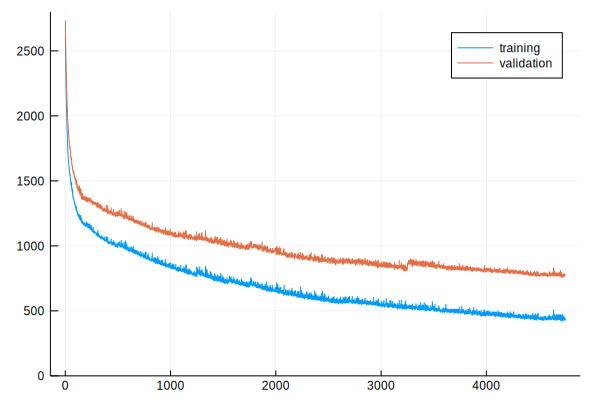

334.081534 seconds (703.27 M allocations: 39.982 GiB, 6.30% gc time)


Progress:  95%|███████████████████████████████████████  |  ETA: 0:31:04

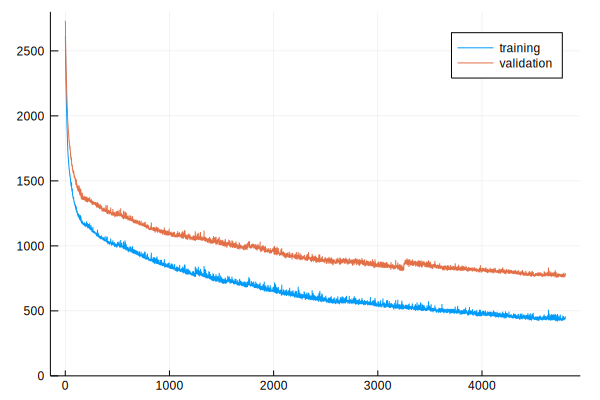

288.252982 seconds (706.83 M allocations: 40.184 GiB, 6.69% gc time)


Progress:  96%|███████████████████████████████████████  |  ETA: 0:24:50

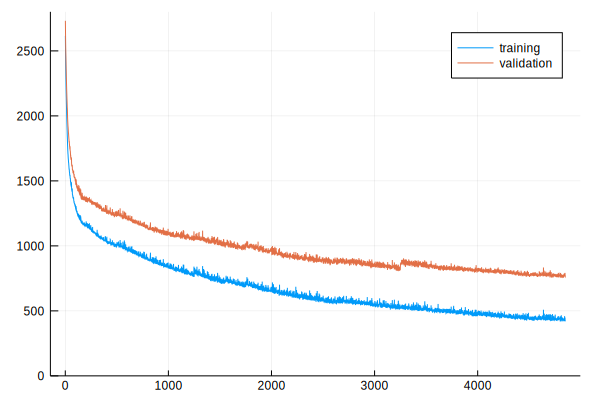

283.542886 seconds (710.38 M allocations: 40.386 GiB, 6.96% gc time)


Progress:  97%|████████████████████████████████████████ |  ETA: 0:18:45

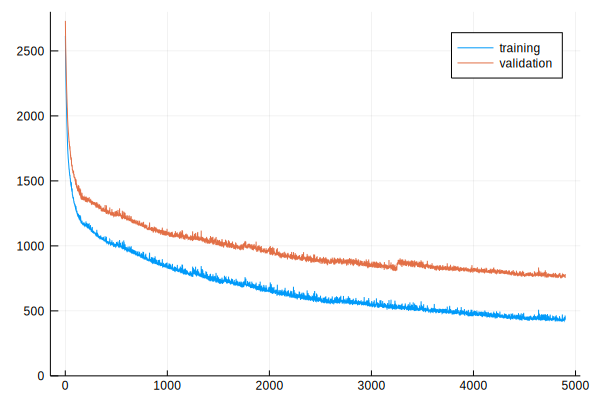

298.222747 seconds (713.94 M allocations: 40.588 GiB, 6.59% gc time)


Progress:  98%|████████████████████████████████████████ |  ETA: 0:12:29

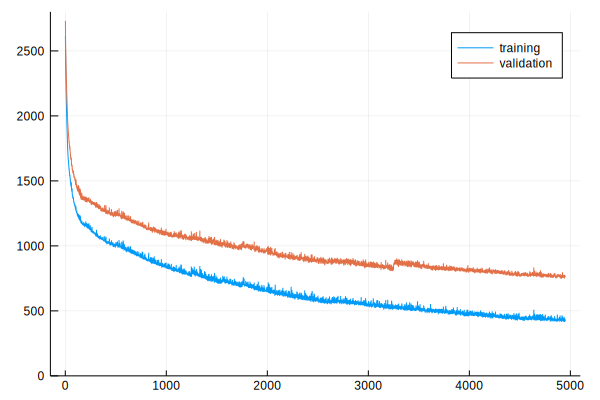

290.023642 seconds (717.49 M allocations: 40.790 GiB, 6.78% gc time)


Progress:  99%|█████████████████████████████████████████|  ETA: 0:06:14

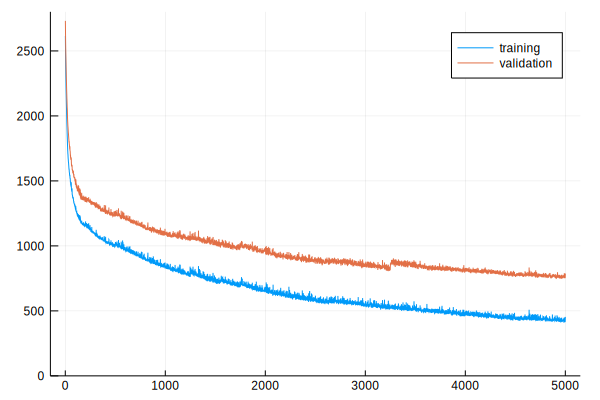

357.451853 seconds (721.05 M allocations: 40.992 GiB, 5.92% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 10:25:25


In [45]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 5.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, σv * i / N_iter)
    end
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end
    
    new_samples = tuple.(dataset.training_data)
    if !isempty(new_samples)
        new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
        append!(all_training_data, new_training)
        append!(all_validation_data, new_validation)
    end

    @time for i in 1:50
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
#     jldopen(library_file, "w") do file
#         file["training"] = all_training_data
#         file["testing"] = all_validation_data
#     end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)

end